# LangGraph

In [1]:
MAIN_AGENT_PROMPT = """### You are an expert appointment booking agent for a spa establishment.

You will receive messages from customers asking to book an appointment. At any given time, there can only be one appointment. 

Your tasks include:
1. Providing available time slots when customers ask for availability during a certain time period.
2. Offering alternative time slots if the requested time is already booked.
3. Ask for the following data at the end of your first response: 
- Get customer's name
- Get appointment's duration (30 minutes, 45 minutes, 60 minutes, or 90 minutes duration)
- Get appointment start time
4. Booking the appointment if the customer decides to proceed. Please make sure to follow the booking policies!
5. When you decide to book appointment, please do things in this following order:
- Make sure you have the customer's name
- Make sure you have the appointment's duration (30 minutes, 45 minutes, 60 minutes, or 90 minutes duration)
- Make sure you have the appointment's start time
- Call book_appointment function

### Booking policies
- Business hours starts at 9 AM and ends at 6 PM (Bali's time/GMT+8)
- Customers can book between 30 minutes, 45 minutes, 60 minutes, and 90 minutes duration
- Booking can only be done in minute 00,15,30,45. Example of valid options: 10.00, 10.15. Example of INVALID options: 10.03, 10.37
   
### Instructions:
- Be polite and professional in your interactions.
- Always confirm the details of the booking with the customer.
- Ensure that there are no overlapping appointments before booking a new one.
- Offer alternative slots that are close to the requested time if the preferred slot is unavailable.
- Confirm the booking with a summary of the details once the appointment is successfully booked.

### Today's date
{date_today}
"""

In [11]:
from typing import Annotated
import pandas as pd
import csv

from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.tools import tool
from langgraph.prebuilt import ToolExecutor, ToolNode, tools_condition
from datetime import datetime, timedelta, timezone

CSV_FILE = '../data/appointments.csv'

# Attempt to get API key from env variable
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    # If you don't have OPENAI_API_KEY set in env variable, please put your API key here to try
    OPENAI_API_KEY = ""

class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools for ChatBot to Call
@tool
def get_available_time(
    date_to_check: Annotated[str, "date to be checked for its time availability"]
) -> str:
    """Call to get available time slot during date_to_check"""

    # Define opening hours
    opening_hour = datetime.strptime(f"{date_to_check} 09:00:00", "%Y-%m-%d %H:%M:%S")
    closing_hour = datetime.strptime(f"{date_to_check} 18:00:00", "%Y-%m-%d %H:%M:%S")
    
    # Read CSV file
    df = pd.read_csv(CSV_FILE)
    
    # Convert 'Date', 'Start', and 'End' columns to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])
    df['Start'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Start'])
    df['End'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['End'])
    
    # Filter the DataFrame for the given date_to_check
    df = df[df['Date'].dt.date == datetime.strptime(date_to_check, "%Y-%m-%d").date()]
    
    # Initialize available time slots
    available_slots = []
    
    # Find gaps between booked slots
    current_time = opening_hour
    for _, row in df.sort_values(by='Start').iterrows():
        start_time = row['Start']
        if current_time < start_time:
            available_slots.append((current_time, start_time))
        current_time = max(current_time, row['End'])
    
    # Check for slot between last booking and closing hour
    if current_time < closing_hour:
        available_slots.append((current_time, closing_hour))
    
    # Format available slots
    available_slots_str = ', '.join([f"{slot[0].strftime('%H.%M')}-{slot[1].strftime('%H.%M')}" for slot in available_slots])
    
    return f"{date_to_check} available at: {available_slots_str}"


@tool
def book_appointment(
    name: Annotated[str, "the name of the customer"], 
    date: Annotated[str, "date of appointment"], 
    start_time: Annotated[str, "start time of appointment, in %H:%M format"], 
    end_time: Annotated[str, "end time of appointment, in %H:%M format"]
) -> str:
    """Function to check if appointment slot is available and book the appointment"""

    # Load current appointments
    with open(CSV_FILE, mode='r') as file:
        appointments = list(csv.DictReader(file))

    # Ensure the datetime strings are correctly formatted
    requested_start = datetime.strptime(f"{date} {start_time}:00", "%Y-%m-%d %H:%M:%S")
    requested_end = datetime.strptime(f"{date} {end_time}:00", "%Y-%m-%d %H:%M:%S")

    for appointment in appointments:
        appointment_start = datetime.strptime(f"{appointment['Date']} {appointment['Start']}", "%Y-%m-%d %H:%M:%S")
        appointment_end = datetime.strptime(f"{appointment['Date']} {appointment['End']}", "%Y-%m-%d %H:%M:%S")

        # Check for overlap
        if requested_start < appointment_end and requested_end > appointment_start:
            return "Slot already booked, please choose another one."

    # Book the appointment
    new_appointment = {
        "Name": name,
        "Date": date,
        "Start": f"{start_time}:00",
        "End": f"{end_time}:00"
    }
    appointments.append(new_appointment)

    # Write appointment to CSV file if booking is valid
    with open(CSV_FILE, mode='w', newline='') as file:
        fieldnames = ['Name', 'Date', 'Start', 'End']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(appointments)
    
    return f"Booking for {name} on {date} from {start_time} to {end_time} is successful!"

# Chatbot Definition
def chatbot(state: State):
    today = datetime.now(timezone(timedelta(hours=8))).strftime("Today is %A, %d %B %Y")
    user_message = HumanMessage(content=f"{state['messages']}")
    messages = [
        SystemMessage(
            content=MAIN_AGENT_PROMPT.format(date_today=today)
        ),
        user_message
    ]
    response = llm.invoke(messages)
    return {"messages": [response]}

tools = [get_available_time, book_appointment]
tool_executor = ToolExecutor(tools)
graph_builder = StateGraph(State)
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0, openai_api_key=OPENAI_API_KEY)
llm = llm.bind_tools(tools)

# Define Node
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))

# Define edges
graph_builder.set_entry_point("chatbot")
graph_builder.add_conditional_edges(
    "chatbot", tools_condition
)
graph_builder.add_edge("tools", "chatbot")


memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(checkpointer=memory)

In [71]:
def get_available_time(
    date_to_check: Annotated[str, "date to be checked for its time availability"]
) -> str:
    """Call to get available time slot during date_to_check"""

    # Define opening hours
    opening_hour = datetime.strptime(f"{date_to_check} 09:00:00", "%Y-%m-%d %H:%M:%S")
    closing_hour = datetime.strptime(f"{date_to_check} 18:00:00", "%Y-%m-%d %H:%M:%S")
    
    # Get current time in GMT+8 and convert to naive datetime
    now = datetime.now(timezone.utc) + timedelta(hours=8)
    now = now.replace(tzinfo=None)

    date_to_check_dt = datetime.strptime(date_to_check, "%Y-%m-%d").date()

    # Handle date checks
    print(now)
    if date_to_check_dt < now.date():
        return f"{date_to_check} is in the past. Bookings for past dates are not allowed."
    
    # If date_to_check is today, adjust opening and closing hours (prevent booking on past time)
    
    if now.date() == date_to_check_dt: 
        opening_hour = max(opening_hour, now)
        if now > closing_hour:
            return "The current time is past closing hours. No available slots today."
    
    # Read CSV file
    df = pd.read_csv(CSV_FILE)
    
    # Convert 'Date', 'Start', and 'End' columns to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])
    df['Start'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Start'])
    df['End'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['End'])
    
    # Filter the DataFrame for the given date_to_check
    df = df[df['Date'].dt.date == datetime.strptime(date_to_check, "%Y-%m-%d").date()]
    
    # Initialize available time slots
    available_slots = []
    
    # Find gaps between booked slots
    current_time = opening_hour
    for _, row in df.sort_values(by='Start').iterrows():
        start_time = row['Start']
        if current_time < start_time:
            available_slots.append((current_time, start_time))
        current_time = max(current_time, row['End'])
    
    # Check for slot between last booking and closing hour
    if current_time < closing_hour:
        available_slots.append((current_time, closing_hour))
    if (available_slots)==[]:
        return f"No timeslot is available for {date_to_check}"
    
    # Format available slots
    available_slots_str = ', '.join([f"{slot[0].strftime('%H.%M')}-{slot[1].strftime('%H.%M')}" for slot in available_slots])
    
    return f"{date_to_check} available at: {available_slots_str}"


In [77]:
get_available_time('2024-07-27')

2024-07-25 23:25:21.128109


'2024-07-27 available at: 09.00-10.00, 11.00-16.00'

In [68]:
def chat_once(user_input):
    config = {"configurable": {"thread_id": "s2saa9"}}
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

In [9]:
chat_once('i want to book appointment for tommorow')

================================ Human Message =================================

i want to book appointment for tommorow
================================== Ai Message ==================================

I can help you with that! Could you please let me know your preferred time for the appointment tomorrow? Additionally, please specify the duration of the appointment (30 minutes, 45 minutes, 60 minutes, or 90 minutes).


In [10]:
chat_once("Eric, 1 hour, 11.00")

================================ Human Message =================================

Eric, 1 hour, 11.00
================================== Ai Message ==================================
Tool Calls:
  get_available_time (call_KXRby9hUskdBubcVpFLGRuo8)
 Call ID: call_KXRby9hUskdBubcVpFLGRuo8
  Args:
    date_to_check: 2024-07-26
================================= Tool Message =================================
Name: get_available_time

2024-07-26 available at: 09.00-10.00
================================== Ai Message ==================================

Thank you for your request, Eric! 

I see that you would like to book a 1-hour appointment starting at 11:00 AM tomorrow, July 26, 2024. However, the only available time slot for that day is from 09:00 AM to 10:00 AM.

Would you like to book the appointment for 09:00 AM instead? If that doesn't work for you, please let me know your preferred time, and I can assist you further! 

Additionally, please confirm the following details:
- Your name: E

In [11]:
chat_once('okay 9am is fine')

================================ Human Message =================================

okay 9am is fine
================================== Ai Message ==================================
Tool Calls:
  book_appointment (call_Cu5nbOxBAHQVnc2kBV6zcjOy)
 Call ID: call_Cu5nbOxBAHQVnc2kBV6zcjOy
  Args:
    name: Eric
    date: 2024-07-26
    start_time: 09:00
    end_time: 10:00
================================= Tool Message =================================
Name: book_appointment

Booking for Eric on 2024-07-26 from 09:00 to 10:00 is successful!
================================== Ai Message ==================================

Your appointment has been successfully booked!

**Appointment Details:**
- **Name:** Eric
- **Date:** July 26, 2024
- **Start Time:** 09:00 AM
- **Duration:** 60 minutes

If you have any further questions or need assistance, feel free to ask. Enjoy your time at the spa!


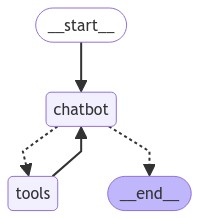

In [54]:
# (OPTIONAL) - Visualize Graph - Requires additional requirement: pygraphiz
# install with: conda install --channel conda-forge pygraphviz
# or check: https://pygraphviz.github.io/documentation/stable/install.html
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Simple Chat Bot with input()
config = {"configurable": {"thread_id": "2s1sss"}}
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    events = graph.stream(
        {"messages": [("user", user_input)]}, config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

i want to book for this weekend, what time are you available?
================================== Ai Message ==================================
Tool Calls:
  get_available_time (call_cWclfhu3Vl4LflqjVEs1qaLr)
 Call ID: call_cWclfhu3Vl4LflqjVEs1qaLr
  Args:
    date_to_check: 2024-07-20
================================= Tool Message =================================
Name: get_available_time

2024-07-20 available at: 09.00-10.00
================================== Ai Message ==================================

We have availability for appointments on Saturday, 20th July 2024, from 09:00 to 10:00 AM. 

Please let me know:
- Your name
- The duration of the appointment (30 minutes, 45 minutes, 60 minutes, or 90 minutes)
- The start time you prefer within the available slot. 

Looking forward to your response!
================================ Human Message =================================

how about on sunday?
=